In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data exploration

### Leture du fichier symbols_valid_meta.csv

In [3]:
symbols = pd.read_csv("data/files/symbols_valid_meta.csv")
symbols.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100.0,N,NaN,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100.0,N,NaN,AADR,AADR,N


On filtre les stocks pour ne garder que ceux séléctionnés dans le notebook EX_5.

In [62]:
# On filtre pour le plus avoir les ETF
symbols = symbols[symbols['ETF'] == 'N']

with open('data/stocks_name.txt', 'r') as f:
    stocks_name = f.read().splitlines()

symbols = symbols[symbols['Symbol'].isin(stocks_name)]
symbols.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
7,Y,AAME,Atlantic American Corporation - Common Stock,Q,G,N,100.0,N,N,NaN,AAME,N
210,Y,AIRT,"Air T, Inc. - Common Stock",Q,G,N,100.0,N,N,NaN,AIRT,N
262,Y,ALOT,"AstroNova, Inc. - Common Stock",Q,G,N,100.0,N,N,NaN,ALOT,N
309,Y,AMOT,"Allied Motion Technologies, Inc. - Common Stock",Q,G,N,100.0,N,N,NaN,AMOT,N
319,Y,AMRN,Amarin Corporation plc - American Depositary S...,Q,G,N,100.0,N,N,NaN,AMRN,N


### Lecture d'un fichier stocks

In [63]:
AAME = pd.read_csv("data/files/stocks/AAME.csv")
AAME.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,4.05,3.85,3.85,3.213167,15000
1,1980-03-18,0.0,4.00,3.80,3.80,3.171437,10200
2,1980-03-19,0.0,4.05,3.85,3.85,3.213167,33500
3,1980-03-20,0.0,4.00,3.80,3.80,3.171437,8700
4,1980-03-21,0.0,3.95,3.75,3.75,3.129709,12700


### On cherche la date la plus ancienne commune à tous les stocks

In [64]:
dir = "./data/files/stocks"

m = 100000
for s in symbols['Symbol']:
    data = pd.read_csv(dir + "/" + s + ".csv")
    if data.shape[0] < m:
        m = data.shape[0]

m

6072

On verifie que la derniere data est bien la même pour tous les fichiers

In [65]:
data = pd.read_csv(f"{dir}/{symbols['Symbol'].iloc[0]}.csv")
end_date = data['Date'].iloc[-1]
print(end_date)
for s in symbols['Symbol'].iloc[1:]:
    data = pd.read_csv(f"{dir}/{s}.csv")
    if data['Date'].iloc[-1] != end_date:
        print(s)

2020-04-01


In [66]:
symbols['Symbol'].iloc[0]

'AAME'

On ne s'interesse qu'au 6072 derniers jours

In [67]:
AAME = AAME.iloc[-m:, :].reset_index(drop=True)

# Calculer  le return et le Log return

Return d'un asset: on not $p_t$ la valeur de l'asset a la date $t$. Alors le return est donné par 

$r_t = \frac{p_{t} - p_{t-1}}{p_{t-1}}$.

Pour le calcul, on prend en compte les valeurs des assets a chaque fermeture de marché. On prend la fermeture ajusté pour la calculer.

In [68]:
def compute_returns(adj_close):
    returns = []
    for i in range(1, len(adj_close)):
        returns.append((adj_close[i] - adj_close[i - 1]) / adj_close[i - 1])
    return returns

In [69]:
returns = compute_returns(AAME['Adj Close'])

Log returns: on définit le log return de la manière suivante : 

$z_t = \log(1 + r_{t})$

Ou si on utilise les prix : 

$z_t = \log(\frac{P_t}{P_{t-1}})$

In [70]:
def compute_log_returns(prices):
    prices = pd.Series(prices)
    log_returns = np.log(prices / prices.shift(1))
    return log_returns

In [71]:
def compute_volatility(prices, window_size=None):
    if not window_size:
        returns = compute_log_returns(prices)
        return np.array(returns).std() * np.sqrt(252)
    returns = compute_log_returns(prices)
    returns = pd.Series(returns)
    rolling_vol = returns.rolling(window=window_size).std()[window_size:].to_numpy()
    return rolling_vol * np.sqrt(252)

# Pour les returns classiques
log_returns = compute_log_returns(AAME['Adj Close'])

vol = compute_volatility(AAME['Adj Close'], 50)
vol

array([0.90096757, 0.93860473, 0.93860473, ..., 1.08368008, 1.08398932,
       1.08462224], shape=(6022,))

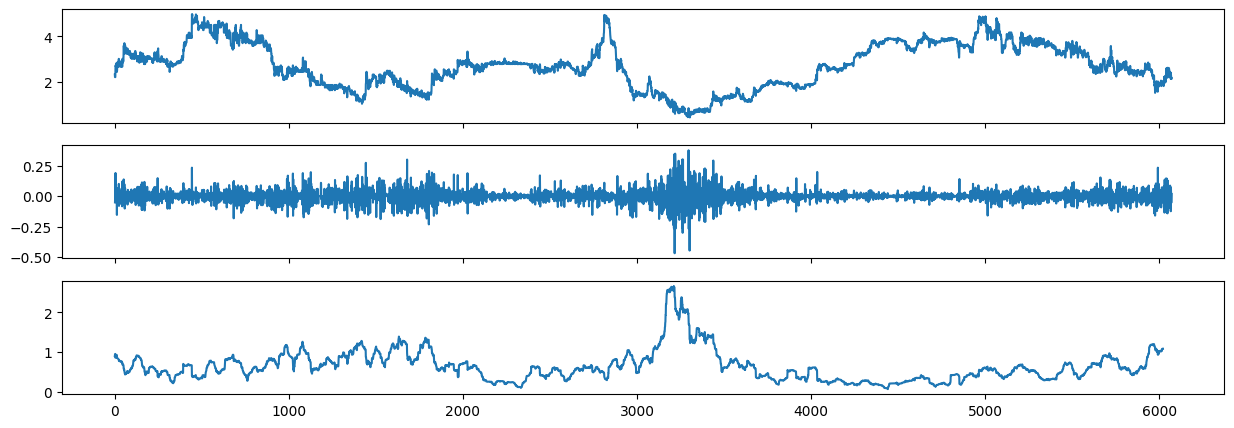

In [72]:
fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
ax[0].plot(AAME['Adj Close'])
ax[1].plot(log_returns)
ax[2].plot(vol)
plt.show()

# Calcul de la volatilité

Pour calculer la volatilité historique d'une action on calcule l'écart-type des returns.

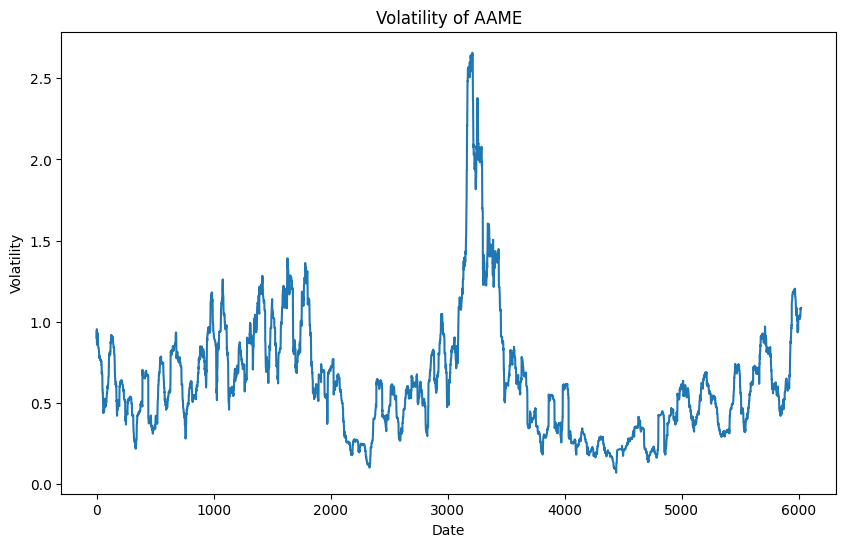

In [73]:

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(vol)
ax.set_title('Volatility of AAME')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
plt.show()

# Correlation

In [78]:
stock_data = dict()

for s in stocks_name:
    data = pd.read_csv(f"{dir}/{s}.csv")
    data = data.iloc[-m:, :].reset_index(drop=True)
    stock_data[s] = data['Adj Close'].values

df_stock = pd.DataFrame(stock_data)

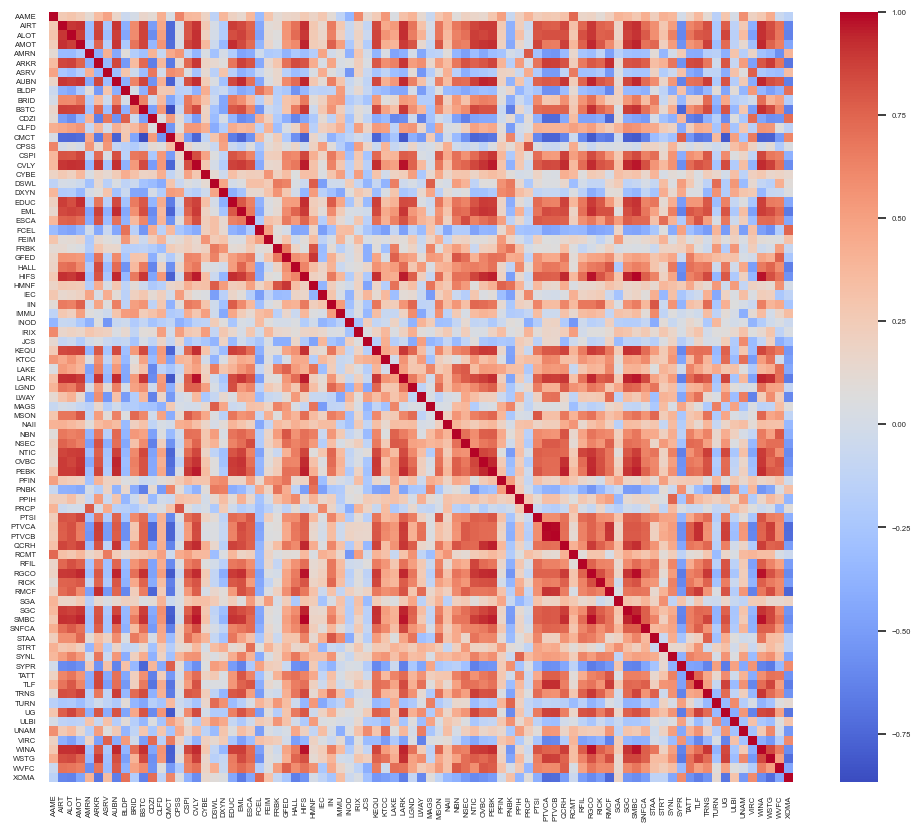

In [81]:
# plot the correlation matrix

fig = plt.figure(figsize=(12, 10))
sns.heatmap(df_stock.corr(), annot=False, cmap="coolwarm")
sns.set(font_scale=0.5)
plt.show()

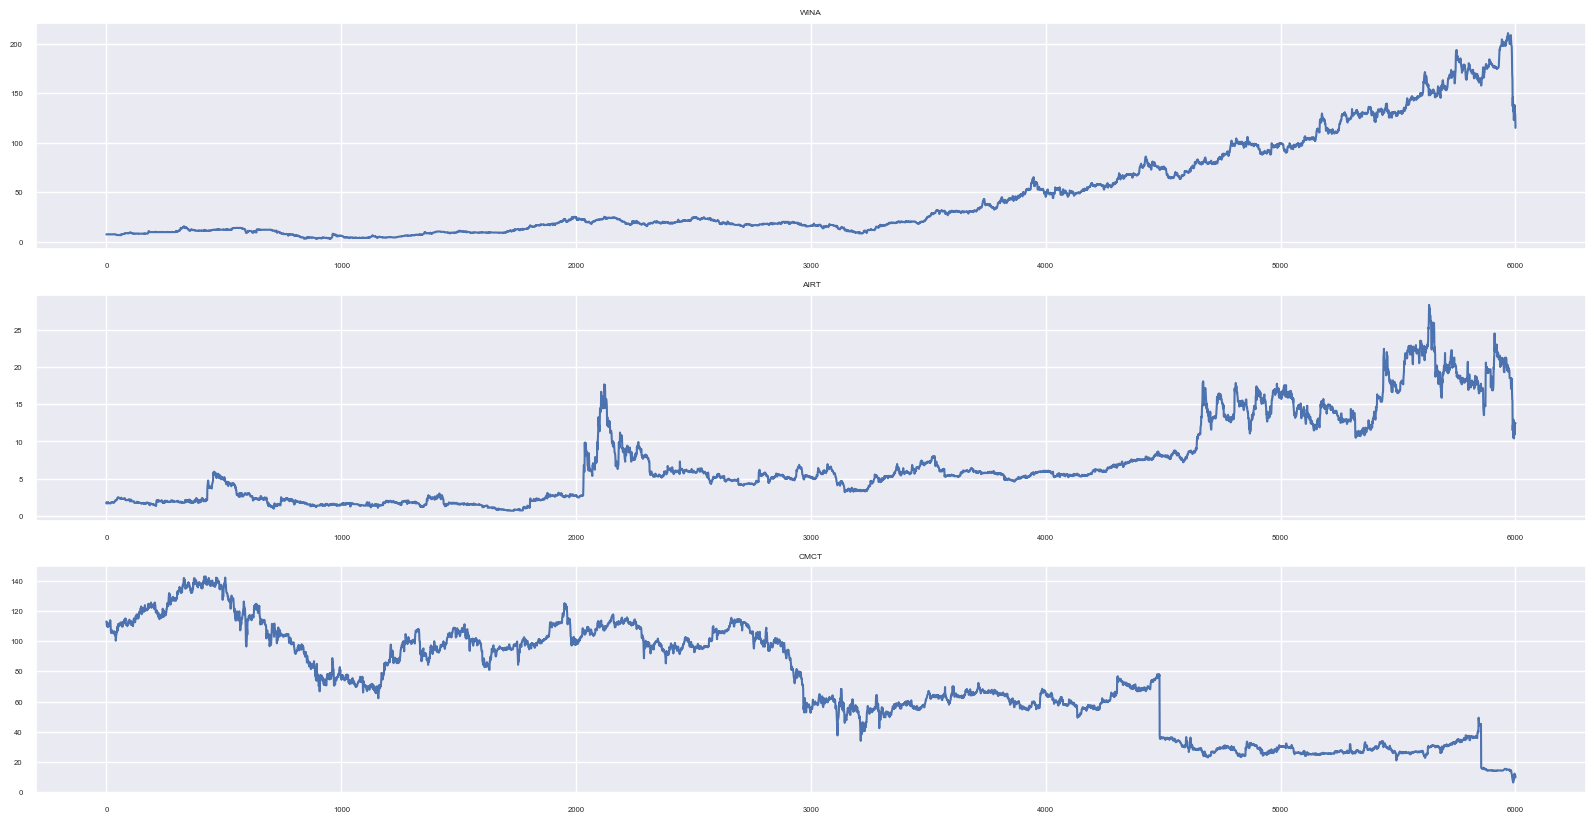

In [80]:
dir = "data/files/stocks"
m = 6001

WINA = pd.read_csv(f"{dir}/WINA.csv").iloc[-m:, :].reset_index(drop=True)
AIRT = pd.read_csv(f"{dir}/AIRT.csv").iloc[-m:, :].reset_index(drop=True)
CMCT = pd.read_csv(f"{dir}/CMCT.csv").iloc[-m:, :].reset_index(drop=True)

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].plot(WINA['Adj Close'])
ax[0].set_title('WINA')
ax[1].plot(AIRT['Adj Close'])
ax[1].set_title('AIRT')
ax[2].plot(CMCT['Adj Close'])
ax[2].set_title('CMCT')
plt.show()